<a href="https://colab.research.google.com/github/MADEENOH/ANLY699-Thesis-Trust-Signals/blob/main/LLM_Fine_Tuning_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cell 1

In [ ]:
!nvidia-smi

Thu Jun 26 22:48:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# Cell 2

In [ ]:
!pip install -q unsloth



# Cell 3

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


# cell 4

In [ ]:
# needed as this function doesn't like it when the lm_head has its size changed
from unsloth import tokenizer_utils

def do_nothing(*args, **kwargs):
    pass

tokenizer_utils.fix_untrained_tokens = do_nothing


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


# cell 5

In [ ]:
import torch
print(f"CUDA Capability: {torch.cuda.get_device_capability()}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unsloth import FastLanguageModel
from transformers import TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Number of classes (2 = binary classification: recommended or not)
NUM_CLASSES = 2

# Model setup
model_name = "unsloth/mistral-7b-bnb-4bit"
load_in_4bit = True
max_seq_length = 2048  # reduce if needed
dtype = None  # Let Unsloth auto-detect

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    load_in_4bit = load_in_4bit,
    max_seq_length = max_seq_length,
    dtype = dtype,
)


CUDA Capability: (8, 0)
==((====))==  Unsloth 2025.6.8: Fast Mistral patching. Transformers: 4.52.4.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


# Cell 6

In [ ]:
# Cell 6 (Corrected)

import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

input_path = "/content/data/Womens Clothing E-Commerce Reviews.csv"
data = pd.read_csv(input_path)

# Keep only needed columns and remove missing rows
data = data[['Review Text', 'Recommended IND']].dropna()
data = data.rename(columns={'Review Text': 'text', 'Recommended IND': 'label'})

# Use a sample as instructed
data = data.sample(n=5000, random_state=42)

# ✅ CHANGE: Map labels to text for more natural learning
data['label'] = data['label'].map({0: "Not Recommended", 1: "Recommended"})

# Check label distribution
print("Label distribution:")
print(data['label'].value_counts())
print("\n" + "="*30 + "\n")

# Train/validation split
train_df, val_df = train_test_split(data, test_size=0.1, random_state=42)
print("Train size:", len(train_df), "Val size:", len(val_df))
print("\nExample validation data:")
print(val_df.head())

Label distribution:
label
Recommended        4103
Not Recommended     897
Name: count, dtype: int64


Train size: 4500 Val size: 500

Example validation data:
                                                    text            label
14735  I've rarely met a maeve item i didnt like. ini...  Not Recommended
104    Runs big and looked unflattering. i am petite,...  Not Recommended
14169  The buttons on the back are very tedious. you ...  Not Recommended
9311   I received many compliments on this top. it's ...      Recommended
19142  The green is vibrant and beautiful, and the sw...      Recommended


# visuals EDA  

This block contains the code for the Recommendation Distribution and the Review Length Histogram.

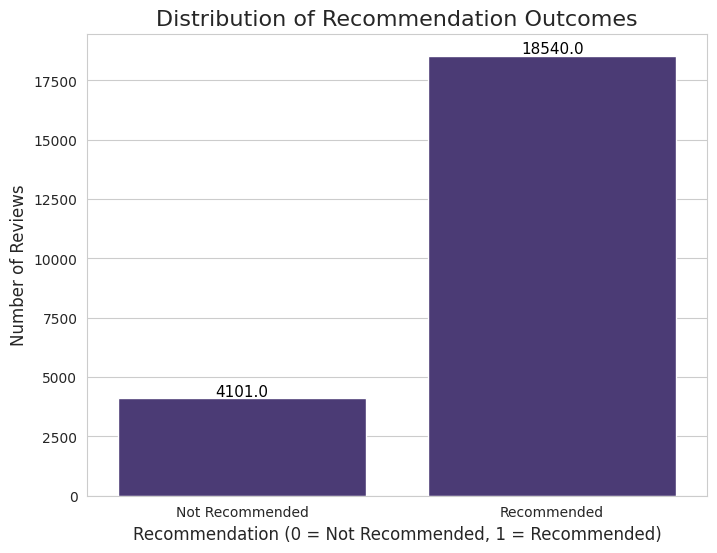

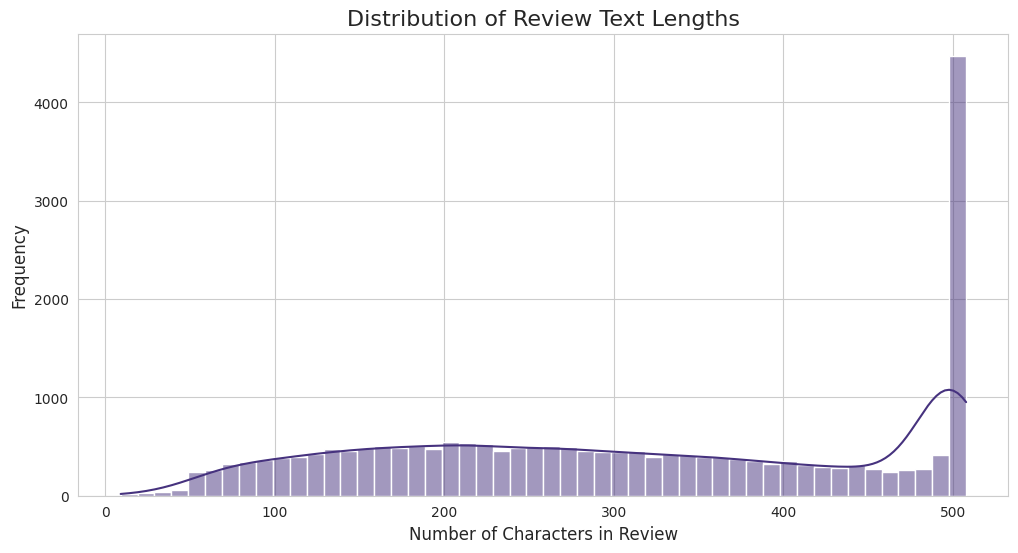

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the style for our plots
sns.set_style("whitegrid")
sns.set_palette("viridis")

# Load the original data
input_path = "/content/data/Womens Clothing E-Commerce Reviews.csv"
original_data = pd.read_csv(input_path).dropna(subset=['Review Text', 'Recommended IND'])

# --- Visualization 1: Distribution of Recommendation Outcomes ---
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Recommended IND', data=original_data)
plt.title('Distribution of Recommendation Outcomes', fontsize=16)
plt.xlabel('Recommendation (0 = Not Recommended, 1 = Recommended)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
ax.set_xticklabels(['Not Recommended', 'Recommended'])
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()


# --- Visualization 2: Distribution of Review Text Lengths ---
original_data['review_length'] = original_data['Review Text'].str.len()
plt.figure(figsize=(12, 6))
sns.histplot(original_data['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Text Lengths', fontsize=16)
plt.xlabel('Number of Characters in Review', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# cell 7

In [ ]:
# Corrected Data Preparation Cell (Formatting + Tokenization)

from datasets import Dataset

# Define a clear, non-leaky prompt template for instruction-tuning
prompt_template = """Classify the sentiment of the following clothing review.
Answer with only 'Recommended' or 'Not Recommended'.

### Review:
{}

### Sentiment:
{}"""

# We need to add the EOS (End Of Sentence) token to the end of each example
# so the model knows when to stop generating.
EOS_TOKEN = tokenizer.eos_token

# 1. Formatting Function
def formatting_func(example):
    # This creates the full prompt with the answer for training
    full_text = prompt_template.format(example['text'], example['label']) + EOS_TOKEN
    return { "text": full_text }

# 2. Tokenizing Function
def tokenize_function(examples):
    # Tokenize the text, truncating sequences that are too long
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=max_seq_length, # This was defined in one of your first cells
    )

# Apply formatting to get a dataset with a 'text' column
formatted_train_dataset = Dataset.from_pandas(train_df).map(formatting_func, remove_columns=list(train_df.columns))
formatted_val_dataset = Dataset.from_pandas(val_df).map(formatting_func, remove_columns=list(val_df.columns))

# Apply tokenization to that dataset.
# `batched=True` makes this process much faster.
# `remove_columns=["text"]` deletes the now-unnecessary text column.
train_dataset = formatted_train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
val_dataset = formatted_val_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

print("✅ Data preparation complete. The dataset now contains 'input_ids'.")
print("\nExample of a tokenized sample:")
print(train_dataset[0])

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

✅ Data preparation complete. The dataset now contains 'input_ids'.

Example of a tokenized sample:
{'__index_level_0__': 7422, 'input_ids': [1, 4950, 1575, 272, 21790, 302, 272, 2296, 13278, 4058, 28723, 13, 2820, 16981, 395, 865, 464, 1925, 1805, 2508, 28742, 442, 464, 2601, 1298, 1805, 2508, 4135, 13, 13, 27332, 8349, 28747, 13, 28737, 2016, 272, 3181, 3356, 3181, 432, 1798, 28723, 272, 9304, 460, 14214, 2066, 298, 576, 395, 579, 1287, 1722, 2783, 1309, 347, 4842, 304, 1876, 575, 28723, 272, 4646, 403, 3659, 28723, 613, 2056, 586, 4123, 1669, 10312, 28723, 13, 13, 27332, 318, 308, 2487, 28747, 13, 1925, 1805, 2508, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


# CELL 8 PEFT

In [ ]:
# New Cell 2: PEFT Model Setup

# We don't need to change the lm_head.
# We target all linear layers for LoRA adaptation.
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
)

Unsloth: Already have LoRA adapters! We shall skip this step.


In [ ]:
# Diagnostic Cell
import transformers
import unsloth
import torch

print("--- Library Versions ---")
print(f"Unsloth version:       {unsloth.__version__}")
print(f"Transformers version:  {transformers.__version__}")
print(f"Torch version:         {torch.__version__}")
print("\n" + "="*50 + "\n")

print("--- TrainingArguments Documentation ---")
# This prints the official documentation for the TrainingArguments class
# that is active in your notebook environment.
from transformers import TrainingArguments
help(TrainingArguments)

--- Library Versions ---
Unsloth version:       2025.6.8
Transformers version:  4.52.4
Torch version:         2.7.0+cu126


--- TrainingArguments Documentation ---
Help on class TrainingArguments in module transformers.training_args:

class TrainingArguments(builtins.object)
 |  TrainingArguments(output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, 

# Cell 19 Define TrainingArguments & Initialize Trainer

In [ ]:
# Cell 19 (Final Solution - Safe Mode)

from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

print("Initializing Trainer in 'Safe Mode' to bypass the library bug.")
print("Evaluation arguments will be removed, and we will evaluate manually after training.")

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    # We remove eval_dataset from the Trainer for now.
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    args=TrainingArguments(
        output_dir="outputs",
        per_device_train_batch_size=8,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        num_train_epochs=3, # You can set this back to 3
        learning_rate=5e-5,
        logging_steps=10,
        optim="adamw_8bit",
        bf16=True,
        fp16=False,
        seed=3407,
        # All problematic evaluation and saving strategy arguments are removed.
        # The model will save at the end of training.
        report_to="none",
    ),
)

print("✅ Trainer initialized successfully in safe mode.")

Initializing Trainer in 'Safe Mode' to bypass the library bug.
Evaluation arguments will be removed, and we will evaluate manually after training.
✅ Trainer initialized successfully in safe mode.


/tmp/ipython-input-17-1510162613.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Cell 20 Train the Model

In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,500 | Num Epochs = 3 | Total steps = 423
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 4 x 1) = 32
 "-____-"     Trainable parameters = 41,943,040/7,000,000,000 (0.60% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,2.373000
20,1.676900
30,1.564400
40,1.583600
50,1.523100
60,1.526400
70,1.480800
80,1.480800
90,1.465900
100,1.459300


TrainOutput(global_step=423, training_loss=1.445372777627715, metrics={'train_runtime': 1705.266, 'train_samples_per_second': 7.917, 'train_steps_per_second': 0.248, 'total_flos': 1.0117185473396736e+17, 'train_loss': 1.445372777627715, 'epoch': 3.0})

# Training Loss Curve

This block creates the plot showing how your model's loss decreased during training.

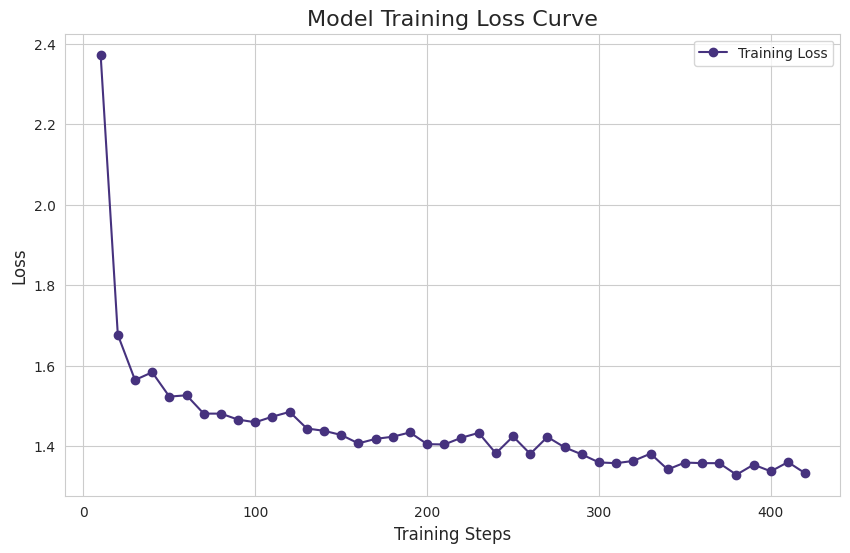

In [ ]:
import matplotlib.pyplot as plt

# The trainer object holds the history of the training process
log_history = trainer.state.log_history

# Extract loss and steps from the log history
steps = []
losses = []
for log in log_history:
    if 'loss' in log:
        steps.append(log['step'])
        losses.append(log['loss'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o', linestyle='-', label="Training Loss")
plt.title('Model Training Loss Curve', fontsize=16)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Cell 21 Inference

This part evaluates the model on the val set with batched inference

In [ ]:
# Cell 21 (Corrected)
from transformers import TextStreamer
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

# Set up the prompt template for inference (the model fills in what's after "Sentiment:")
inference_template = """Classify the sentiment of the following clothing review.
Answer with only 'Recommended' or 'Not Recommended'.

### Review:
{}

### Sentiment:
"""

# Get the original texts and true labels from the validation dataframe
original_reviews = val_df['text'].tolist()
true_labels = val_df['label'].tolist()
predicted_labels = []

# Ensure model is in eval mode
model.eval()

print("Starting inference on the validation set...")
with torch.no_grad():
    for review in tqdm(original_reviews):
        # Format the prompt for inference
        prompt = inference_template.format(review)
        inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

        # Generate the text output
        # max_new_tokens=5 is enough for "Recommended" or "Not Recommended"
        outputs = model.generate(**inputs, max_new_tokens=5, eos_token_id=tokenizer.eos_token_id)

        # Decode the generated part
        decoded_output = tokenizer.batch_decode(outputs[:, inputs.input_ids.shape[1]:], skip_special_tokens=True)[0]

        # Clean the output and store it
        cleaned_output = decoded_output.strip()
        predicted_labels.append(cleaned_output)

# --- Calculate Metrics ---
print("\nInference Complete. Calculating metrics...")

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.4f}")

# Generate full classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, labels=["Recommended", "Not Recommended"]))

Starting inference on the validation set...


100%|██████████| 500/500 [04:59<00:00,  1.67it/s]


Inference Complete. Calculating metrics...

Accuracy: 0.9220

Classification Report:
                 precision    recall  f1-score   support

    Recommended       0.94      0.96      0.95       411
Not Recommended       0.80      0.74      0.77        89

       accuracy                           0.92       500
      macro avg       0.87      0.85      0.86       500
   weighted avg       0.92      0.92      0.92       500



# Confusion Matrix (For a new cell after Cell 21)

This block visualizes the final performance of your model from the classification report.

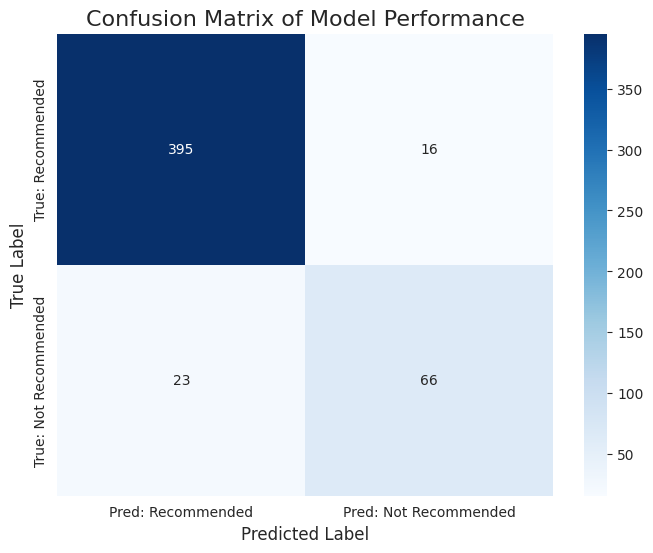

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# This code assumes the 'true_labels' and 'predicted_labels' lists from your
# evaluation cell (Cell 21) are still in memory.

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=["Recommended", "Not Recommended"])

# Create a DataFrame for better labeling
cm_df = pd.DataFrame(cm,
                     index=['True: Recommended', 'True: Not Recommended'],
                     columns=['Pred: Recommended', 'Pred: Not Recommended'])

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Model Performance', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

In [ ]:
from huggingface_hub import login
login()

In [ ]:
# Save the final, merged model for easy inference
# This combines the original Mistral model with your trained LoRA adapters
model.save_pretrained_merged("final_sentiment_model", tokenizer, save_method = "merged_16bit")

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00003.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  33%|███▎      | 1/3 [00:38<01:17, 38.95s/it]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  67%|██████▋   | 2/3 [01:34<00:48, 48.56s/it]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 3/3 [02:25<00:00, 48.40s/it]


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

print("Loading the final, merged model from disk...")
# Load the final model that you saved locally
model_path = "final_sentiment_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path)

# --- IMPORTANT ---
# Define the name for your new model repository on the Hub.
# You MUST replace 'your-hf-username' with your actual Hugging Face username.
repo_id = "MadeEnoh/mistral-7b-clothing-sentiment-v1"

print(f"\nUploading model to the Hugging Face Hub at: {repo_id}")
print("This may take several minutes as the model files are large...")

# Push both the model and the tokenizer to the Hub.
# `private=True` makes the model visible only to you. You can remove this or set it to False to make it public later.
model.push_to_hub(repo_id, private=True)
tokenizer.push_to_hub(repo_id, private=True)

print(f"✅ Success! Your model is now saved on the Hugging Face Hub.")
print(f"You can view it at: https://huggingface.co/{repo_id}")

Loading the final, merged model from disk...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


Uploading model to the Hugging Face Hub at: MadeEnoh/mistral-7b-clothing-sentiment-v1
This may take several minutes as the model files are large...


Uploading...:   0%|          | 0.00/29.0G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Uploading...:   0%|          | 0.00/493k [00:00<?, ?B/s]

✅ Success! Your model is now saved on the Hugging Face Hub.
You can view it at: https://huggingface.co/MadeEnoh/mistral-7b-clothing-sentiment-v1


#Attempt at Keyphrases

Starting key phrase analysis...
Generating plot...


/tmp/ipython-input-1-1377575639.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='phrase', data=df_rec, ax=axes[0], palette='Greens_d')
/tmp/ipython-input-1-1377575639.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='phrase', data=df_not_rec, ax=axes[1], palette='Reds_d')


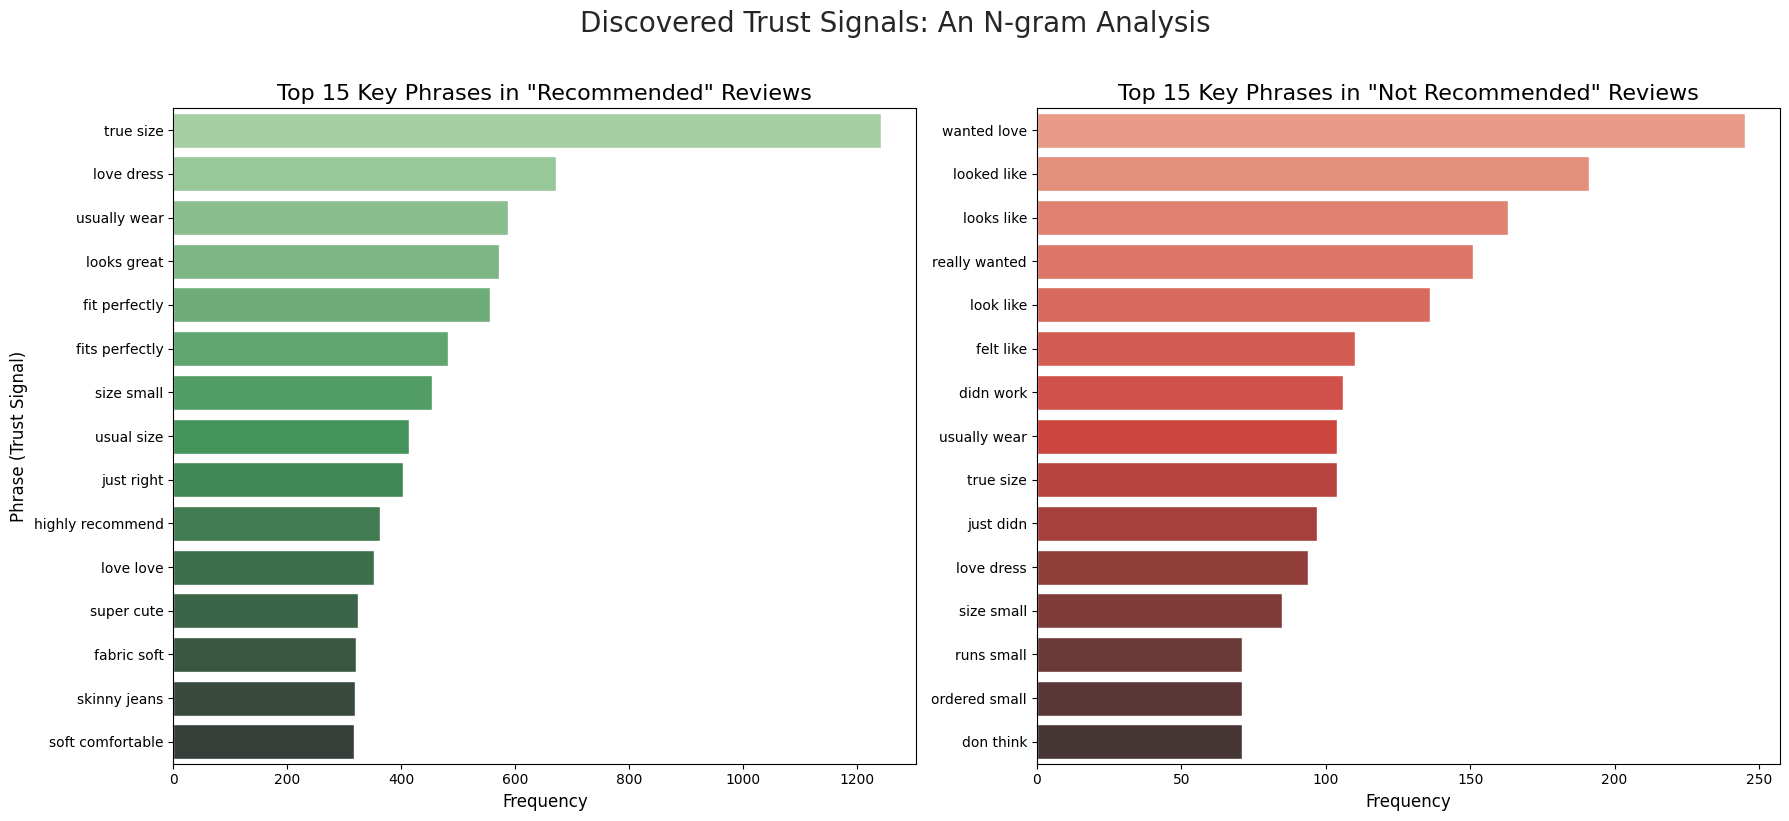


Analysis complete.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

print("Starting key phrase analysis...")

# Load the dataset directly to ensure we have clean data
try:
    input_path = "/content/data/Womens Clothing E-Commerce Reviews.csv"
    original_data = pd.read_csv(input_path).dropna(subset=['Review Text', 'Recommended IND'])
except FileNotFoundError:
    print("Error: Dataset file not found. Please ensure the path is correct.")

# Function to get the top n-grams (phrases) from a body of text
def get_top_ngrams(corpus, n=None, ngram_range=(2, 2)):
    # Use CountVectorizer to count the frequency of 2-word phrases
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Separate the review text into two categories
recommended_corpus = original_data[original_data['Recommended IND'] == 1]['Review Text']
not_recommended_corpus = original_data[original_data['Recommended IND'] == 0]['Review Text']

# Get the top 15 most frequent phrases for each category
top_phrases_recommended = get_top_ngrams(recommended_corpus, n=15)
top_phrases_not_recommended = get_top_ngrams(not_recommended_corpus, n=15)

# Convert the results to a DataFrame for easy plotting
df_rec = pd.DataFrame(top_phrases_recommended, columns=['phrase', 'count'])
df_not_rec = pd.DataFrame(top_phrases_not_recommended, columns=['phrase', 'count'])

# --- Create the Visualization ---
print("Generating plot...")
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# Plot for "Recommended" phrases
sns.barplot(x='count', y='phrase', data=df_rec, ax=axes[0], palette='Greens_d')
axes[0].set_title('Top 15 Key Phrases in "Recommended" Reviews', fontsize=16)
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_ylabel('Phrase (Trust Signal)', fontsize=12)

# Plot for "Not Recommended" phrases
sns.barplot(x='count', y='phrase', data=df_not_rec, ax=axes[1], palette='Reds_d')
axes[1].set_title('Top 15 Key Phrases in "Not Recommended" Reviews', fontsize=16)
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_ylabel('') # Hide redundant label

plt.suptitle('Discovered Trust Signals: An N-gram Analysis', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

print("\nAnalysis complete.")



### Story of the Charts


